In [2]:
import sqlite3
import requests
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import os
import requests
import time
from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
import time


In [7]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 3.9 MB/s eta 0:00:39
   ---------------------------------------- 1.6/150.0 MB 4.7 MB/s eta 0:00:32
    --------------------------------------- 2.9/150.0 MB 5.2 MB/s eta 0:00:29
   - -------------------------------------- 4.5/150.0 MB 5.9 MB/s eta 0:00:25
   - -------------------------------------- 6.3/150.0 MB 6.5 MB/s eta 0:00:23
   -- ------------------------------------- 7.9/150.0 MB 6.6 MB/s eta 0:00:22
   -- ------------------------------------- 11.0/150.0 MB 7.8 MB/s eta 0:00:18
   --- ------------------------------------ 14.9/150.0 MB 9.2 MB/s eta 0:00:15
   ----- ---------------------------------- 18.9/150.0 MB 10.3 MB/s eta 0:00:13
   ----- ---------------------------------- 21.8/150.0 MB 10.7 MB/s eta 0:00:13
   ------ --------------------------------- 25.7/150.0 MB 11.4 MB/s eta 0:00:11
   -------- ------------------------------- 30.4/150.0 MB 12.5 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
conn = sqlite3.connect("Database/news_data.db")

In [4]:
df = pd.read_sql_query("""
                        SELECT 
                            ticker
                        FROM Stocks
                        """, conn)

tickers = df["ticker"].values.tolist()

In [22]:
len(tickers)

23

In [148]:
def get_complete_df(tickers, future_time_offset):
    """
    Fetch and process data for the given tickers with a customizable future time offset.

    Parameters:
    - tickers: List of stock tickers.
    - future_time_offset: String representing the time offset for future price (e.g., '+1 hour', '+2 hours', '+1 day').

    Returns:
    - A DataFrame containing the processed data.
    """
    dfs_list = []
    for ticker in tickers:
        query = f"""
            SELECT 
                a.ticker,
                a.url,
                a.title,
                a.summary,
                a.source_domain,
                a.closest_time_before_published,
                datetime(a.closest_time_before_published, '{future_time_offset}') AS 'future_time',
                CASE
                    WHEN TIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '{future_time_offset}') > '19:50:00'
                    THEN DATE(REPLACE(a.closest_time_before_published, '+00:00', ''), '+1 day') || ' 13:30:00'
                    ELSE DATETIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '{future_time_offset}')
                END AS adjusted_future_time,
                s.open AS open_price,
                f.close AS future_price,
                a.time_published
            FROM {ticker}_NewsArticles AS a
            LEFT JOIN {ticker}PriceHistory AS s 
                ON a.closest_time_before_published = s.date
            LEFT JOIN {ticker}PriceHistory AS f 
                ON REPLACE(f.date, '+00:00', '') = adjusted_future_time
        """

        # Execute the query and fetch the data
        df = pd.read_sql_query(query, conn)
        print(f"Fetched {len(df)} rows for ticker: {ticker}")
        dfs_list.append(df)

    # Combine all dataframes into one
    complete_df = pd.DataFrame()
    for df in dfs_list:
        if not df.empty:
            df = df.drop_duplicates(subset=["summary", "title"])
            complete_df = pd.concat([complete_df, df], ignore_index=True)

    # Drop rows with missing values
    complete_df = complete_df.dropna()

    print(f"Final DataFrame columns: {complete_df.columns}")
    print(f"Total rows in complete DataFrame: {len(complete_df)}")

    return complete_df

In [ ]:
dfs_list = []
for ticker in tickers:
    query = f"""
            SELECT 
                a.ticker,
                a.url,
                a.title,
                a.summary,
                a.source_domain,
                a.closest_time_before_published,
                datetime(a.closest_time_before_published, '1+ hour') AS 'future_time',
                CASE
                    WHEN TIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '1+ hour') > '19:50:00'
                    THEN DATE(REPLACE(a.closest_time_before_published, '+00:00', ''), '+1 day') || ' 13:30:00'
                    ELSE DATETIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '1+ hour')
                END AS adjusted_future_time,
                s.open AS open_price,
                f.close AS future_price,
                a.time_published
            FROM {ticker}_NewsArticles AS a
            LEFT JOIN {ticker}PriceHistory AS s 
                ON a.closest_time_before_published = s.date
            LEFT JOIN {ticker}PriceHistory AS f 
                ON REPLACE(f.date, '+00:00', '') = adjusted_future_time
        """

    # Execute the query and fetch the data
    df = pd.read_sql_query(query, conn)
    print(f"Fetched {len(df)} rows for ticker: {ticker}")
    dfs_list.append(df)


final_df = pd.DataFrame()

for df in dfs_list:
    if not df.empty:
        ticker = df["ticker"][0]
        grouped = df.groupby('source_domain').size().reset_index(name=f'{ticker}_frequency')
        final_df = pd.concat([final_df, grouped], ignore_index=True)


"final_df = final_df.groupby('source_domain').sum().reset_index()\nprint(final_df.sort_values(by='frequency', ascending=False))"

In [34]:
final_df["sum_frequency"] = final_df.filter(like='_frequency').sum(axis=1)

In [42]:
grouped_final_df = final_df.groupby('source_domain').sum(numeric_only=True).reset_index()

In [45]:
len(grouped_final_df)

52

In [42]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 10000)

In [62]:

grouped_final_df[grouped_final_df["sum_frequency"] > 500].sort_values(by='sum_frequency', ascending=False)

,source_domain,AAPL_frequency,MSFT_frequency,NVDA_frequency,BAC_frequency,GS_frequency,PLD_frequency,O_frequency,SPG_frequency,XOM_frequency,CVX_frequency,SLB_frequency,AMZN_frequency,WMT_frequency,TGT_frequency,KO_frequency,PG_frequency,PEP_frequency,JNJ_frequency,PFE_frequency,NFLX_frequency,DIS_frequency,sum_frequency
23,www.benzinga.com,697.0,406.0,321.0,296.0,503.0,85.0,78.0,134.0,552.0,545.0,531.0,332.0,465.0,405.0,259.0,284.0,412.0,436.0,443.0,384.0,488.0,8056.0
51,www.zacks.com,345.0,263.0,257.0,138.0,116.0,217.0,267.0,397.0,1064.0,1137.0,871.0,340.0,127.0,544.0,305.0,340.0,238.0,336.0,244.0,234.0,145.0,7925.0
33,www.fool.com,360.0,260.0,426.0,417.0,196.0,199.0,855.0,98.0,600.0,855.0,24.0,618.0,274.0,280.0,516.0,302.0,399.0,208.0,285.0,242.0,59.0,7473.0
39,www.investors.com,98.0,36.0,77.0,18.0,22.0,5.0,2.0,18.0,52.0,130.0,158.0,60.0,16.0,42.0,20.0,45.0,12.0,25.0,9.0,26.0,3.0,874.0
27,www.cnbc.com,11.0,55.0,88.0,121.0,65.0,2.0,5.0,36.0,84.0,6.0,34.0,11.0,61.0,9.0,23.0,51.0,41.0,37.0,50.0,33.0,21.0,844.0
37,www.globenewswire.com,0.0,30.0,10.0,39.0,52.0,6.0,0.0,10.0,96.0,10.0,84.0,1.0,24.0,3.0,44.0,40.0,34.0,117.0,140.0,36.0,19.0,795.0
34,www.forbes.com,10.0,53.0,40.0,18.0,20.0,12.0,3.0,32.0,72.0,24.0,14.0,2.0,47.0,11.0,44.0,31.0,36.0,38.0,31.0,176.0,52.0,766.0
45,www.prnewswire.com,2.0,29.0,11.0,16.0,15.0,20.0,35.0,20.0,40.0,20.0,34.0,0.0,26.0,15.0,34.0,61.0,69.0,53.0,59.0,15.0,75.0,649.0


In [64]:
grouped_final_df[grouped_final_df["sum_frequency"] > 500].sort_values(by='sum_frequency', ascending=False)[["source_domain","sum_frequency"]]

,source_domain,sum_frequency
23,www.benzinga.com,8056.0
51,www.zacks.com,7925.0
33,www.fool.com,7473.0
39,www.investors.com,874.0
27,www.cnbc.com,844.0
37,www.globenewswire.com,795.0
34,www.forbes.com,766.0
45,www.prnewswire.com,649.0


Model testing

In [149]:
complete_df = get_complete_df(tickers, '+1 hour')

Fetched 1680 rows for ticker: AAPL
Fetched 1371 rows for ticker: MSFT
Fetched 1375 rows for ticker: NVDA
Fetched 0 rows for ticker: JPM
Fetched 1412 rows for ticker: BAC
Fetched 1376 rows for ticker: GS
Fetched 606 rows for ticker: PLD
Fetched 1285 rows for ticker: O
Fetched 811 rows for ticker: SPG
Fetched 2822 rows for ticker: XOM
Fetched 2851 rows for ticker: CVX
Fetched 1908 rows for ticker: SLB
Fetched 1395 rows for ticker: AMZN
Fetched 1395 rows for ticker: WMT
Fetched 1429 rows for ticker: TGT
Fetched 1411 rows for ticker: KO
Fetched 1384 rows for ticker: PG
Fetched 1417 rows for ticker: PEP
Fetched 1343 rows for ticker: JNJ
Fetched 1385 rows for ticker: PFE
Fetched 1437 rows for ticker: NFLX
Fetched 1170 rows for ticker: DIS
Fetched 0 rows for ticker: CMCSA
Final DataFrame columns: Index(['ticker', 'url', 'title', 'summary', 'source_domain',
       'closest_time_before_published', 'future_time', 'adjusted_future_time',
       'open_price', 'future_price', 'time_published'],
   

In [63]:
complete_df.tail()

,ticker,url,title,summary,source_domain,closest_time_before_published,1 hour after published,future_time,open_price,future_price,time_published
26382,DIS,https://www.fool.com/earnings/call-transcripts...,Lindblad Expeditions ( LIND ) Q3 2024 Earnin...,LIND earnings call for the period ending Septe...,www.fool.com,2024-11-05 18:40:00+00:00,2024-11-05 19:40:00,2024-11-05 19:40:00,96.530,96.460,20241105T184517
26384,DIS,https://www.fool.com/earnings/call-transcripts...,fuboTV ( FUBO ) Q1 2024 Earnings Call Transc...,FUBO earnings call for the period ending March...,www.fool.com,2024-05-03 16:00:00+00:00,2024-05-03 17:00:00,2024-05-03 17:00:00,113.235,113.525,20240503T160016
26385,DIS,https://www.fool.com/investing/2024/10/21/the-...,The Semiconductor Stories of TSMC & ASML,"We also check in with Bob Stark, author of ""Th...",www.fool.com,2024-10-21 15:50:00+00:00,2024-10-21 16:50:00,2024-10-21 16:50:00,96.425,96.290,20241021T155200
26386,DIS,https://www.fool.com/earnings/call-transcripts...,Coca-Cola ( KO ) Q2 2024 Earnings Call Trans...,KO earnings call for the period ending June 30...,www.fool.com,2024-07-23 17:10:00+00:00,2024-07-23 18:10:00,2024-07-23 18:10:00,90.860,91.340,20240723T171520
26387,DIS,https://www.forbes.com/sites/sethmatlins/2024/...,The 2024 Forbes World's Most Influential CMOs ...,The 12th annual Forbes World's Most Influentia...,www.forbes.com,2024-06-19 19:50:00+00:00,2024-06-19 20:50:00,2024-06-20 13:30:00,101.490,100.850,20240620T103000


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [123]:

class MarketSentiment:
    def __init__(self):
        self.news_data = None
        self.price_data = None
        self.labeled_data = None
        self.model = None
        self.vectorizer = None
        self.important_features = None    


    def preprocess_text(self, use_lemmatization=True):
        """
        Preprocess headlines and summaries for NLP
        """
        if self.labeled_data is None or len(self.labeled_data) == 0:
            print("No labeled data available for preprocessing")
            return
            
        # Combine headline and summary
        self.labeled_data['text'] = self.labeled_data['headline'] + ' ' + self.labeled_data['summary'].fillna('')
        
        # Initialize lemmatizer if needed
        lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        
        # Get English stopwords
        stop_words = set(stopwords.words('english'))
        
        # Add financial terms that are too common to be useful
        financial_stopwords = {'stock', 'stocks', 'market', 'markets', 'company', 
                              'share', 'shares', 'price', 'prices', 'investor', 
                              'investors', 'trading', 'trader', 'traders', 'report',
                              'reports', 'reported', 'quarter', 'quarterly', 'fiscal',
                              'financial', 'earnings', 'revenue', 'revenues', 'profit',
                              'profits', 'loss', 'losses'}
        stop_words.update(financial_stopwords)
        
        # Function to clean text
        def clean_text(text):
            if not isinstance(text, str):
                return ""
                
            # Convert to lowercase
            text = text.lower()
            
            # Remove special characters and numbers
            text = re.sub(r'[^\w\s]', ' ', text)
            text = re.sub(r'\d+', ' ', text)
            
            # Tokenize
            tokens = word_tokenize(text)
            
            # Remove stopwords and lemmatize if required
            if use_lemmatization:
                cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
            else:
                cleaned_tokens = [token for token in tokens if token not in stop_words]
                
            # Join tokens back into text
            return ' '.join(cleaned_tokens)
            
        # Apply text cleaning
        print("Preprocessing text data...")
        labeled_data['cleaned_text'] = labeled_data['text'].apply(clean_text)
        
        # Remove empty texts
        labeled_data = labeled_data[self.labeled_data['cleaned_text'].str.strip() != '']
        print(f"After preprocessing: {len(self.labeled_data)} articles")
    


    def preprocess_data(self, df, method='tfidf', max_features=3000, ngram_range=(1, 2), use_lemmatization=True):
        """
        Preprocess the raw data to prepare for training
        """
        print("Preprocessing data...")
        lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        
        # Get English stopwords
        stop_words = set(stopwords.words('english'))
        
        # Add financial terms that are too common to be useful
        financial_stopwords = {'stock', 'stocks', 'market', 'markets', 'company', 
                              'share', 'shares', 'price', 'prices', 'investor', 
                              'investors', 'trading', 'trader', 'traders', 'report',
                              'reports', 'reported', 'quarter', 'quarterly', 'fiscal',
                              'financial', 'earnings', 'revenue', 'revenues'}
        stop_words.update(financial_stopwords)
        # Combine title and summary
        df.loc[:, 'text'] = df['title'].fillna('') + ' ' + df['summary'].fillna('')
        # Compute future return (simple price delta or percentage)
        df.loc[:, 'future_return'] = df['future_price'] - df['open_price']

        def clean_text(text):
            if not isinstance(text, str):
                return ""
                
            # Convert to lowercase
            text = text.lower()
            
            # Remove special characters and numbers
            text = re.sub(r'[^\w\s]', ' ', text)
            text = re.sub(r'\d+', ' ', text)
            
            # Tokenize
            tokens = word_tokenize(text)
            
            # Remove stopwords and lemmatize if required
            if use_lemmatization:
                cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
            else:
                cleaned_tokens = [token for token in tokens if token not in stop_words]
                
            # Join tokens back into text
            return ' '.join(cleaned_tokens)
        

        # Store the labeled data
        self.labeled_data = df

        print("Preprocessing text data...")
        self.labeled_data.loc[:, 'cleaned_text'] = self.labeled_data['text'].apply(clean_text)
        
        # Remove empty texts
        self.labeled_data = self.labeled_data[self.labeled_data['cleaned_text'].str.strip() != '']
        print(f"After preprocessing: {len(self.labeled_data)} articles")

        if method == 'count':
            self.vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
        else:  # default to tfidf
            self.vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
        # Vectorize text
        X = self.vectorizer.fit_transform(self.labeled_data['cleaned_text'])

        # Convert sparse matrix to DataFrame
        X_df = pd.DataFrame(X.toarray(), columns=self.vectorizer.get_feature_names_out())

        return X_df, self.labeled_data

    def build_model(self, X_df, target='future_return', test_size=0.2, random_state=42):
        """
        Build and evaluate models (Linear, Random Forest, GPU XGBoost RF)
        """
        if self.labeled_data is None or X_df is None:
            print("No data available for model building")
            return

        if target not in self.labeled_data.columns:
            print(f"Target column '{target}' not found in data")
            return

        print(f"Building models to predict {target}...")

        y = self.labeled_data[target].values
        X_train, X_test, y_train, y_test = train_test_split(
            X_df, y, test_size=test_size, random_state=random_state
        )
        self.X_train = X_train

        print(f"Training set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")

        models = {
            'Linear Regression': LinearRegression(),
            'XGBoost RF': XGBRFRegressor(
                        n_estimators=100,
                        learning_rate=1,
                        max_depth=10,
                        subsample=0.8,
                        colsample_bynode=0.8,
                        tree_method='hist',
                        device='cuda',
                        verbosity=1
                    )
        }

        results = {}

        # Train sklearn models
        for name, model in models.items():
            if name == "XGBoost RF":
                try:
                    print("Training XGBoost (GPU Random Forest)...")
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)
                    r2 = r2_score(y_test, y_pred)

                    print(f"XGBoost RF - MSE: {mse:.4f}, R²: {r2:.4f}")
                    results['XGBoost RF'] = {
                        'model': model,
                        'mse': mse,
                        'r2': r2,
                        'y_test': y_test,
                        'y_pred': y_pred
                    }
                except Exception as e:
                    print("XGBoost RF training failed:", e)
            else:
                print(f"Training {name}...")
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                print(f"{name} - MSE: {mse:.4f}, R²: {r2:.4f}")
                results[name] = {
                    'model': model,
                    'mse': mse,
                    'r2': r2,
                    'y_test': y_test,
                    'y_pred': y_pred
                }
        

        # Select best model
        best_model_name = max(results, key=lambda k: results[k]['r2'])
        self.model = results[best_model_name]['model']
        print(f"Best model: {best_model_name} with R² = {results[best_model_name]['r2']:.4f}")

        # Extract features only if supported
        if best_model_name in ['Linear Regression', 'XGBoost RF']:
            self.extract_important_features(X_df.columns, best_model_name, self.model)

        return results

    
    def extract_important_features(self, feature_names, model_name, model):
        """
        Extract and visualize important features from the model
        """
        print("Extracting important features...")

        if model_name == 'Linear Regression':
            # For linear regression, use coefficients
            importance = np.abs(model.coef_)
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            })

        elif model_name == 'XGBoost RF':
            # For XGBRFRegressor, use built-in feature_importances_
            try:
                importance = model.feature_importances_
                feature_importance = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importance
                })
            except AttributeError:
                print("Model does not support feature_importances_. Check if it's a trained XGBRFRegressor.")
                return

        else:
            print(f"Feature importance extraction not implemented for {model_name}")
            return

        # Sort and store
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        self.important_features = feature_importance.head(30)

        print("Top 10 most important features:")
        print(self.important_features.head(10))

        return self.important_features

    
    def visualize_results(self, results, target='future_return'):
        """
        Create visualizations of model performance and feature importance
        """
        if results is None or self.important_features is None:
            print("No results or feature importance to visualize")
            return
            
        # Set up plot style
        plt.style.use('seaborn-v0_8-darkgrid')
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Plot actual vs predicted values for each model
        for i, (name, result) in enumerate(results.items()):
            ax = axes[0, i]
            ax.scatter(result['y_test'], result['y_pred'], alpha=0.5)
            ax.plot([-10, 10], [-10, 10], 'r--')  # Perfect prediction line
            ax.set_title(f'{name}: Actual vs Predicted {target}')
            ax.set_xlabel('Actual')
            ax.set_ylabel('Predicted')
            ax.text(0.05, 0.95, f"R² = {result['r2']:.4f}\nMSE = {result['mse']:.4f}", 
                   transform=ax.transAxes, fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 2. Plot top features
        top_n = min(15, len(self.important_features))
        ax = axes[1, 0]
        sns.barplot(x='importance', y='feature', data=self.important_features.head(top_n), ax=ax)
        ax.set_title(f'Top {top_n} Important Features')
        ax.set_xlabel('Importance')
        
        # 3. Plot distribution of target variable
        ax = axes[1, 1]
        sns.histplot(self.labeled_data[target], kde=True, ax=ax)
        ax.set_title(f'Distribution of {target}')
        ax.set_xlabel(target)
        
        plt.tight_layout()
        plt.show()
        
def create_sentiment_lexicon(self, threshold=0.001):
    """
    Create a market-based sentiment lexicon.
    """
    if self.model is None or self.important_features is None:
        print("No model or feature importance available")
        return None

    print("Creating market-based sentiment lexicon...")

    sentiment_dict = {}

    # Linear Regression
    if isinstance(self.model, LinearRegression):
        all_features = self.vectorizer.get_feature_names_out()
        coefficients = self.model.coef_

        for feature, coef in zip(all_features, coefficients):
            if abs(coef) > threshold:
                sentiment = 'positive' if coef > 0 else 'negative'
                sentiment_dict[feature] = {
                    'sentiment': sentiment,
                    'score': coef
                }

    # XGBoost (with built-in importance)
    elif 'XGB' in self.model.__class__.__name__:
        try:
            all_features = self.vectorizer.get_feature_names_out()
            booster = self.model.get_booster()
            importance = booster.get_score(importance_type='gain')

            # Map 'f0', 'f1', ... back to feature names
            feature_map = {f"f{idx}": name for idx, name in enumerate(all_features)}

            for key, coef in importance.items():
                fname = feature_map.get(key, key)
                if abs(coef) > threshold:
                    sentiment = 'positive' if coef > 0 else 'negative'
                    sentiment_dict[fname] = {
                        'sentiment': sentiment,
                        'score': coef
                    }

        except Exception as e:
            print("Falling back to SHAP due to error:", e)

            # Use SHAP values if built-in importance fails
            explainer = shap.Explainer(self.model, self.X_train)
            shap_values = explainer(self.X_train)
            coefficients = shap_values.values.mean(axis=0)

            for feature, coef in zip(all_features, coefficients):
                if abs(coef) > threshold:
                    sentiment = 'positive' if coef > 0 else 'negative'
                    sentiment_dict[feature] = {
                        'sentiment': sentiment,
                        'score': coef
                    }

    else:
        print("Sentiment lexicon creation is only implemented for Linear Regression and XGBoost.")
        return None

    # Create DataFrame
    lexicon = pd.DataFrame.from_dict(sentiment_dict, orient='index')
    lexicon = lexicon.reset_index().rename(columns={'index': 'word'})
    lexicon = lexicon.sort_values('score', ascending=False)

    print(f"Created sentiment lexicon with {len(lexicon)} words")

    print("\nTop positive words:")
    print(lexicon[lexicon['sentiment'] == 'positive'].head(10))

    print("\nTop negative words:")
    print(lexicon[lexicon['sentiment'] == 'negative'].tail(10))

    return lexicon

    
    def test_shap(self):
        explainer = shap.Explainer(self.model, self.X_train)
        shap_values = explainer(self.X_train)
        return explainer, shap_values

Preprocessing data...
Preprocessing text data...
After preprocessing: 15891 articles
Building models to predict future_return...
Training set: 12712 samples, Test set: 3179 samples
Training Linear Regression...
Linear Regression - MSE: 26.2317, R²: -0.2781
Training XGBoost (GPU Random Forest)...


c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:05:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:729: UserWarning: [19:06:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


XGBoost RF - MSE: 20.6871, R²: -0.0080
Best model: XGBoost RF with R² = -0.0080
Extracting important features...
Top 10 most important features:
           feature   importance
30   biotechnology  2672.635742
171           nflx  2241.886475
279       thursday  1721.009644
237            say  1560.841431
288          trump  1424.165283
274         tariff  1394.232422
286       trillion  1259.678955
46        changing  1232.563721
182           part  1211.645508
21              ap  1104.480591


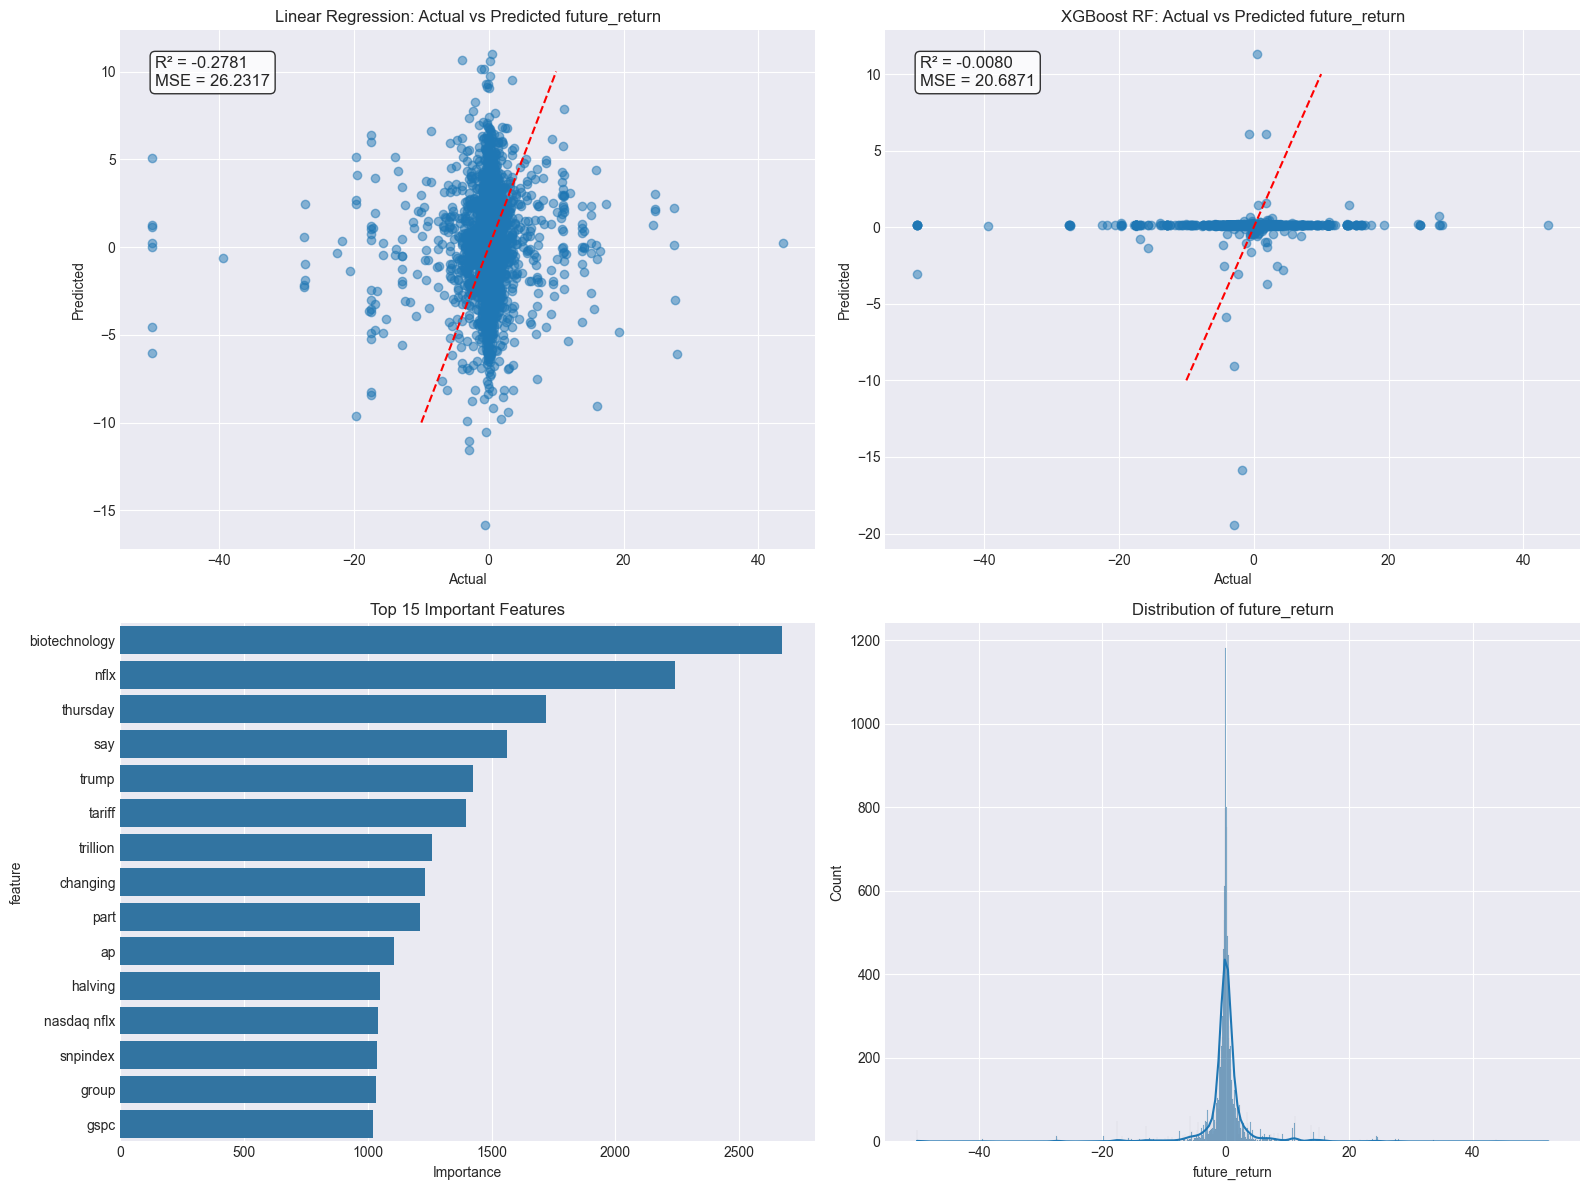

AttributeError: 'MarketSentiment' object has no attribute 'create_sentiment_lexicon'

In [ ]:

# Initialize and preprocess
sentiment_model = MarketSentiment()
X_df, data = sentiment_model.preprocess_data(complete_df)

# Build model
results = sentiment_model.build_model(X_df, target='future_return')

# Visualize results
sentiment_model.visualize_results(results)

# Generate lexicon
lexicon = sentiment_model.create_sentiment_lexicon()


In [72]:
sentiment_model.create_sentiment_lexicon()

Creating market-based sentiment lexicon...
Sentiment lexicon creation only implemented for Linear Regression


hyper search xgboost rf

In [ ]:
sentiment_model = MarketSentiment()
X_df, labeled_data = sentiment_model.preprocess_data(complete_df)

Preprocessing data...
Preprocessing text data...
After preprocessing: 15891 articles


In [126]:
len(labeled_data)

15891

In [127]:
target='future_return'

y = labeled_data[target].values
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=472
)

In [ ]:
try:
    print("Training XGBoost (GPU Random Forest)...")
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        'objective': "reg:squarederror",
        'tree_method' : "hist", 
        'device' : "cuda", # GPU acceleration
        'num_parallel_tree': 100,       # Emulate RF
        'subsample': 0.8,
        'colsample_bynode': 0.8,
        'learning_rate': 1,
        'max_depth': 10,
        'verbosity': 1
    }

    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=1)

    y_pred = xgb_model.predict(dtest)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"XGBoost RF - MSE: {mse:.4f}, R²: {r2:.4f}")
    results['XGBoost RF'] = {
        'model': xgb_model,
        'mse': mse,
        'r2': r2,
        'y_test': y_test,
        'y_pred': y_pred
        }
except Exception as e:
    print("XGBoost RF training failed:", e)

XGBoostRFRegressor

In [ ]:
XGBRFRegressor_model = XGBRFRegressor(
    n_estimators=100,
    learning_rate=1,
    max_depth=10,
    subsample=0.8,
    colsample_bynode=0.8,
    tree_method='hist',
    device='cuda',
    verbosity=1
)


XGBRFRegressor_model.fit(X_train, y_train)
y_pred = XGBRFRegressor_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RF - MSE: {mse:.4f}, R²: {r2:.4f}")
results['XGBoost RF'] = {
    'model': XGBRFRegressor_model,
    'mse': mse,
    'r2': r2,
    'y_test': y_test,
    'y_pred': y_pred
}

XGBoost RF - MSE: 21.7214, R²: -0.0344


c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:729: UserWarning: [19:21:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


XgboostRegressor

In [25]:
from xgboost import XGBRegressor

xgbregressor_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',     # or 'gpu_hist' if using GPU
    device='cuda',          # if using GPU
    random_state=42
)
xgbregressor_model.fit(X_train, y_train)
y_pred = xgbregressor_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost regressor - MSE: {mse:.4f}, R²: {r2:.4f}")
results['XGBoost regressor'] = {
    'model': xgbregressor_model,
    'mse': mse,
    'r2': r2,
    'y_test': y_test,
    'y_pred': y_pred
}

XGBoost regressor - MSE: 21.9191, R²: -0.0438


In [23]:
XGBRFRegressor_model.feature_importances_

array([0.00453341, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], shape=(3000,), dtype=float32)

{'Linear Regression': {'model': LinearRegression(),
  'mse': 26.231716448313275,
  'r2': -0.27813839031966014,
  'y_test': array([-5.455,  0.445,  3.525, ..., -0.6  ,  0.975, -1.09 ], shape=(3179,)),
  'y_pred': array([ 3.28631045,  2.71024841, -1.55574839, ..., -3.50168246,
         -2.36312546, -2.36546032], shape=(3179,))},
 'XGBoost RF': {'model': XGBRFRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bytree=None, device='cuda',
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, feature_weights=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=1, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=10, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=No

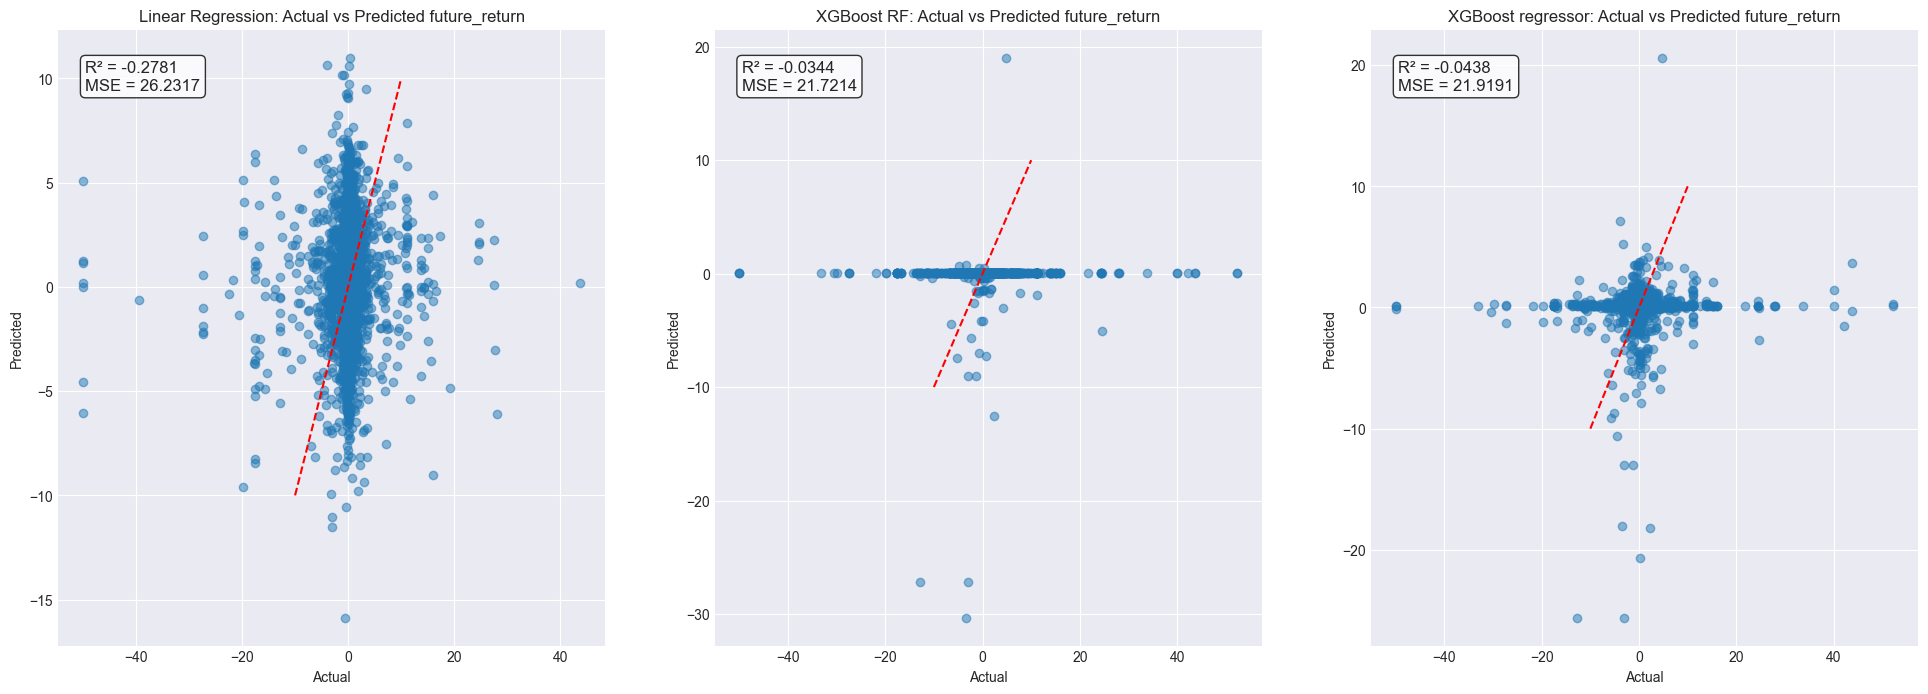

In [40]:
plt.style.use('seaborn-v0_8-darkgrid')
        
# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# 1. Plot actual vs predicted values for each model
for i, (name, result) in enumerate(results.items()):
            ax = axes[i]
            ax.scatter(result['y_test'], result['y_pred'], alpha=0.5)
            ax.plot([-10, 10], [-10, 10], 'r--')  # Perfect prediction line
            ax.set_title(f'{name}: Actual vs Predicted {target}')
            ax.set_xlabel('Actual')
            ax.set_ylabel('Predicted')
            ax.text(0.05, 0.95, f"R² = {result['r2']:.4f}\nMSE = {result['mse']:.4f}", 
                   transform=ax.transAxes, fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

SPlitting into sector wise models

In [150]:
complete_df = get_complete_df(tickers, '+5 hour')

sentiment_model = MarketSentiment()
X_df, labeled_data = sentiment_model.preprocess_data(complete_df)

Fetched 1680 rows for ticker: AAPL
Fetched 1371 rows for ticker: MSFT
Fetched 1375 rows for ticker: NVDA
Fetched 0 rows for ticker: JPM
Fetched 1412 rows for ticker: BAC
Fetched 1376 rows for ticker: GS
Fetched 606 rows for ticker: PLD
Fetched 1285 rows for ticker: O
Fetched 811 rows for ticker: SPG
Fetched 2822 rows for ticker: XOM
Fetched 2851 rows for ticker: CVX
Fetched 1908 rows for ticker: SLB
Fetched 1395 rows for ticker: AMZN
Fetched 1395 rows for ticker: WMT
Fetched 1429 rows for ticker: TGT
Fetched 1411 rows for ticker: KO
Fetched 1384 rows for ticker: PG
Fetched 1417 rows for ticker: PEP
Fetched 1343 rows for ticker: JNJ
Fetched 1385 rows for ticker: PFE
Fetched 1437 rows for ticker: NFLX
Fetched 1170 rows for ticker: DIS
Fetched 0 rows for ticker: CMCSA
Final DataFrame columns: Index(['ticker', 'url', 'title', 'summary', 'source_domain',
       'closest_time_before_published', 'future_time', 'adjusted_future_time',
       'open_price', 'future_price', 'time_published'],
   

In [80]:
# get sectors for each ticker
tickers_sector = pd.read_sql_query("""
                        SELECT 
                            ticker,
                            sector
                        FROM Stocks
                        """, conn)
                        
tickers_sector.head(10)

,ticker,sector
0,AAPL,Technology
1,MSFT,Technology
2,NVDA,Technology
3,JPM,Financials
4,BAC,Financials
5,GS,Financials
6,PLD,Real Estate
7,O,Real Estate
8,SPG,Real Estate
9,XOM,Energy


In [129]:
# Merge sectors onto labeled_data using the ticker column
labeled_data = labeled_data.merge(tickers_sector, on='ticker', how='left')

In [128]:
len(labeled_data)

15891

In [130]:
sectors = labeled_data['sector'].unique()
print(sectors)

['Technology' 'Financials' 'Real Estate' 'Energy' 'E-commerce / Retail'
 'Foods and Consumables' 'Healthcare' 'Entertainment']


using onlt XGB regressor test model on seperate sectors

In [132]:
labeled_data.head(1)

,ticker,url,title,summary,source_domain,closest_time_before_published,1 hour after published,future_time,open_price,future_price,time_published,text,future_return,cleaned_text,sector
0,AAPL,https://www.marketwatch.com/story/apple-card-s...,Apple Card savings account has an attractive 4...,The tech giant recently debuted a new savings ...,www.marketwatch.com,2023-05-02 18:20:00+00:00,2023-05-02 19:20:00,2023-05-02 19:20:00,168.64,168.97,20230502T182500,Apple Card savings account has an attractive 4...,0.33,apple card saving account attractive interest ...,Technology


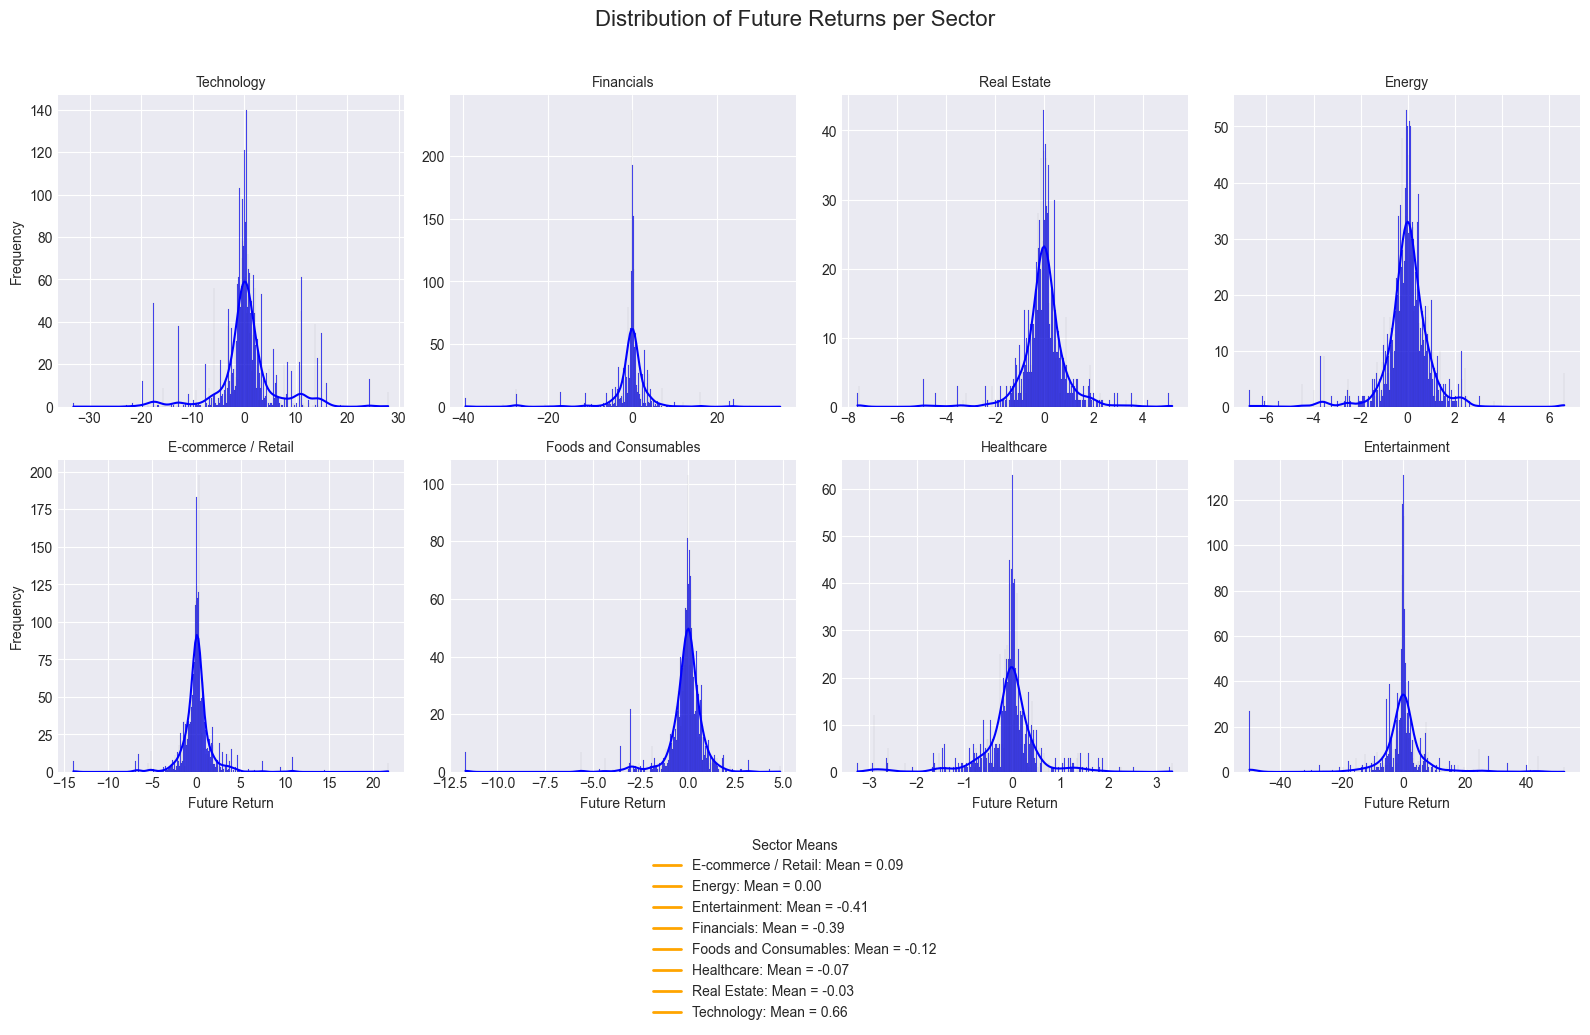

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

sector_means = labeled_data.groupby('sector')['future_return'].mean()
# Set up the FacetGrid
g = sns.FacetGrid(labeled_data, col="sector", col_wrap=4, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "future_return", kde=True, bins=500, color="blue", alpha=0.7)

# Add titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Future Return", "Frequency")
g.fig.suptitle("Distribution of Future Returns +1 hour per Sector", fontsize=16, y=1.02)

# Add a custom legend with the mean values
handles = [plt.Line2D([0], [0], color='orange', lw=2, label=f"{sector}: Mean = {mean:.2f}") 
           for sector, mean in sector_means.items()]
g.fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=1, title="Sector Means")


plt.tight_layout()
plt.show()

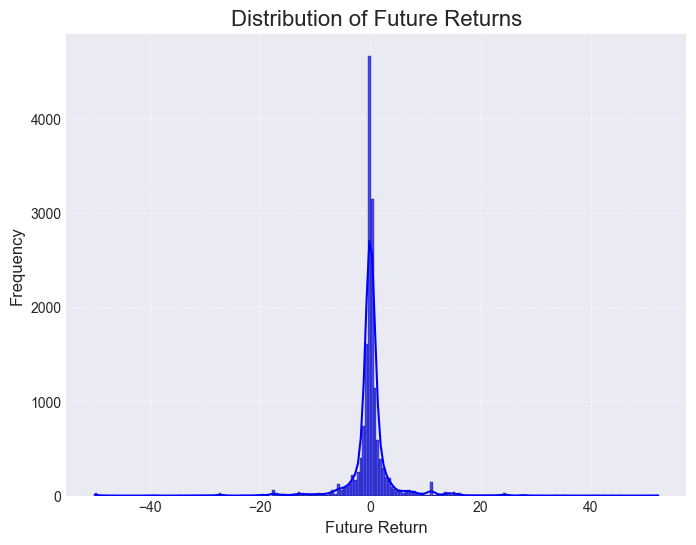

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(labeled_data['future_return'], kde=True, bins=200, color='blue', alpha=0.7)
plt.title('Distribution of Future Returns 1+ hour', fontsize=16)
plt.xlabel('Future Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [143]:
from xgboost import XGBRegressor

sector_results = {}

for sector in sectors:
    print(sector)
    # Filter the data for the current sector
    sector_data = labeled_data[labeled_data['sector'] == sector]
    
    # Check if there are enough samples in the sector
    if len(sector_data) < 10:
        print(f"Not enough data for sector {sector}. Skipping...")
        continue

    # Preprocess the data
    X_df, y_data = sentiment_model.preprocess_data(sector_data)

    # Split the data
    y = y_data[target].values
    X_train, X_test, y_train, y_test = train_test_split(
        X_df, y, test_size=0.2, random_state=472
    )
    xgbregressor_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',     # or 'gpu_hist' if using GPU
        device='cuda',          # if using GPU
        random_state=42
    )
    xgbregressor_model.fit(X_train, y_train)
    y_pred = xgbregressor_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"XGBoost regressor for {sector} - MSE: {mse:.4f}, R²: {r2:.4f}")
    sector_results[f'XGBoost regressor for {sector}'] = {
        'model': xgbregressor_model,
        'mse': mse,
        'r2': r2,
        'y_test': y_test,
        'y_pred': y_pred,
        'sector': sector,
        'feature_importances': xgbregressor_model.feature_importances_
    }

Technology
Preprocessing data...
Preprocessing text data...
After preprocessing: 3164 articles
XGBoost regressor for Technology - MSE: 31.8768, R²: -0.0693
Financials
Preprocessing data...
Preprocessing text data...
After preprocessing: 2006 articles
XGBoost regressor for Financials - MSE: 43.1351, R²: -0.2101
Real Estate
Preprocessing data...
Preprocessing text data...
After preprocessing: 1236 articles
XGBoost regressor for Real Estate - MSE: 1.3817, R²: -0.4150
Energy
Preprocessing data...
Preprocessing text data...
After preprocessing: 1839 articles
XGBoost regressor for Energy - MSE: 1.1010, R²: -0.0720
E-commerce / Retail
Preprocessing data...
Preprocessing text data...
After preprocessing: 2759 articles
XGBoost regressor for E-commerce / Retail - MSE: 5.2239, R²: -0.3242
Foods and Consumables
Preprocessing data...
Preprocessing text data...
After preprocessing: 2003 articles
XGBoost regressor for Foods and Consumables - MSE: 1.4632, R²: -0.0343
Healthcare
Preprocessing data...
P

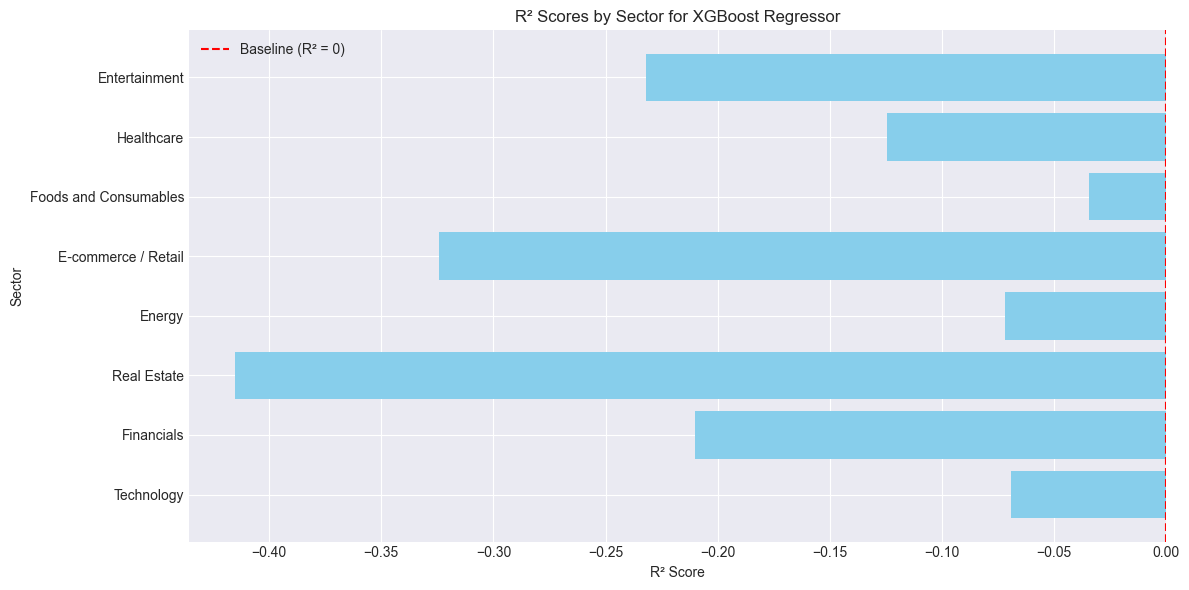

In [144]:
# Extract sector names and R² scores
sector_names = [result['sector'] for result in sector_results.values()]
r2_scores = [result['r2'] for result in sector_results.values()]

# Plot the R² scores for each sector
plt.figure(figsize=(12, 6))
plt.barh(sector_names, r2_scores, color='skyblue')
plt.xlabel('R² Score')
plt.ylabel('Sector')
plt.title('R² Scores by Sector for XGBoost Regressor')
plt.axvline(0, color='red', linestyle='--', label='Baseline (R² = 0)')
plt.legend()
plt.tight_layout()
plt.show()

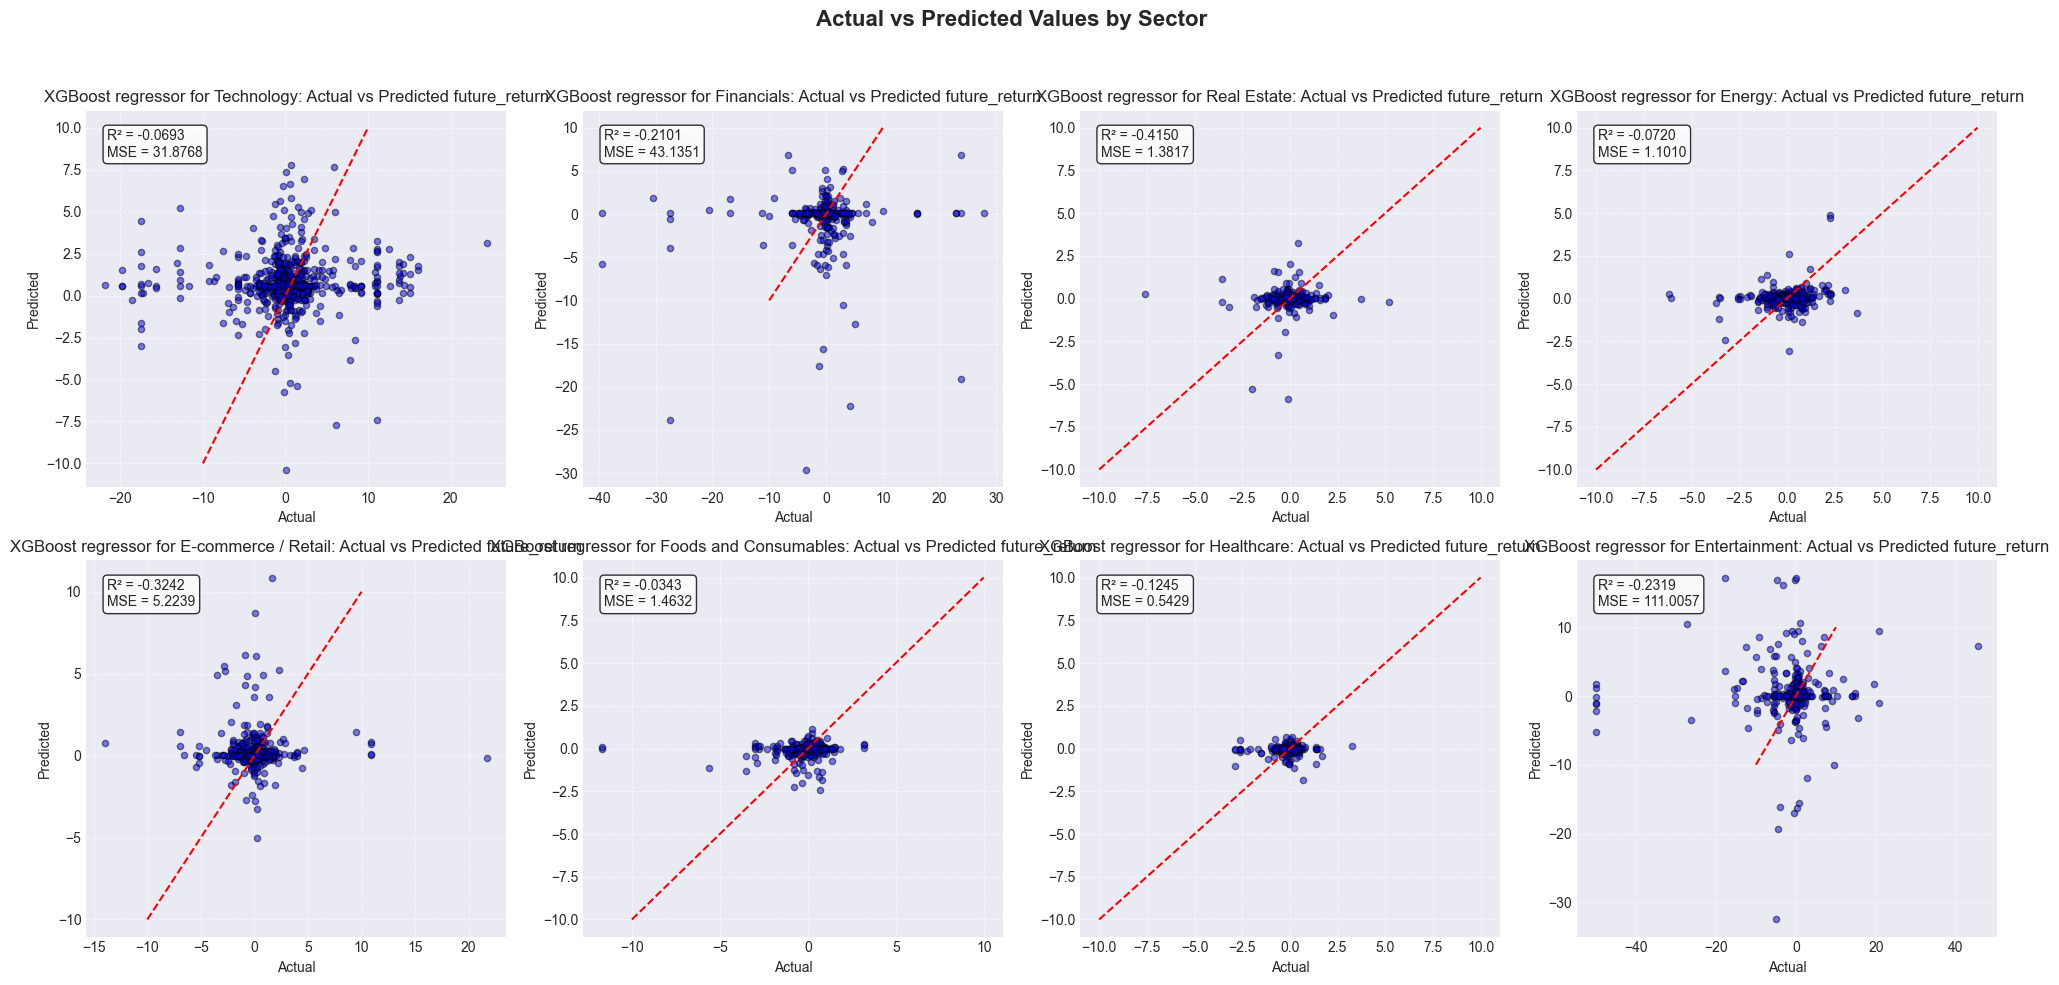

In [145]:
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjusted figure size for better spacing

# Flatten the axes array for easier indexing
axes = axes.flatten()

# 1. Plot actual vs predicted values for each model
for i, (name, result) in enumerate(sector_results.items()):
    ax = axes[i]
    ax.scatter(result['y_test'], result['y_pred'], alpha=0.5, color='blue', edgecolor='k', s=20)
    ax.plot([-10, 10], [-10, 10], 'r--', linewidth=1.5)  # Perfect prediction line
    ax.set_title(f'{name}: Actual vs Predicted {target}', fontsize=12)
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    ax.text(0.05, 0.95, f"R² = {result['r2']:.4f}\nMSE = {result['mse']:.4f}", 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide unused subplots if sector_results has fewer than 8 items
for j in range(len(sector_results), len(axes)):
    fig.delaxes(axes[j])

# Add a main title for the entire figure
fig.suptitle('Actual vs Predicted Values by Sector', fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()